# Hardware test

A first example for inference using a network on the FPGA.

## 480MHz without scaler implementation

![Firmware layout](Images/NN_480MHz.png)

In [1]:
# Imports and defs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patternfiles import *
from bitstringconverter import *

In [2]:
y_test     = np.load("Data/y_test_1ele_sigmoid.npy")
y_test     = np.reshape(y_test, (len(y_test),))
X_test     = np.load("Data/X_test_1ele_sigmoid.npy")

In [3]:
import subprocess

In [4]:
def prep_bitstring_data(data_int_new):
    # Step 1: convert data to integer representation
    data_int_new = convert_to_ap_ufixed(data_int_new, 16, 6)
    
    # Step 2: convert to bitstrings
    formatstring = np.full(17, "uint:16")
    data_bitstring = pack_vec(formatstring, data_int_new)
    
    # Step 3: Add required padding
    data_bitstring_padded = padd_vec(data_bitstring, 16)
    
    return data_bitstring_padded

In [ ]:
debug = False

output_data = {}

chunk_length = 900
max_chunks = 50

#for label, int_data in int_data_options.items():
for chunk in range(max_chunks):
    label = "chunk_%i" %chunk
    print(label)
    
    X_test_chunk = X_test[chunk * chunk_length: (chunk+1) * chunk_length]
    
    data_bitstring_padded = prep_bitstring_data(X_test_chunk)
    # write out fname
    indir = "Pattern_files"
    fname = indir + "/hls4ml_input_pattern_%s.txt" % label
    #fname = indir + "/finor_test_%s.txt" % label
    write_pattern_file(data_bitstring_padded, outputfile=fname, linkOffset=60)
    # checking created fil
    if debug:
        f = open(fname, 'r')
        print(f.readlines()[20])
        

In [ ]:
max_chunks = 50
output_data = {}

#for label, int_data in int_data_options.items():
for chunk in range(max_chunks):
    
    label = "chunk_%i" %chunk
    print(label)
    
    ## read output
    # Step 1: Reading in pattern file
    outputdata_bitstrings = read_pattern_file("Pattern_files/tx_data_480_%s.txt" %label, keepInvalid=False)
    output_data[label] = outputdata_bitstrings
    #print(outputdata_bitstrings)
    
    # Step 2: Unpacking
    formatstring_2 = np.full(4, "int:64")
    outputdata_int = unpack_vec(formatstring_2, outputdata_bitstrings)
    #print(outputdata_int)
    # Step 3: convert to float
    outputdata = convert_from_ap_ufixed(outputdata_int, 8, 0)
    
    output_data[label] = outputdata

In [ ]:
max_chunks = 50
output_data = {}
column = []
labels = ["3_layers", "2_layers", "1_layer", "4_nodes"]
result = {}
for label in labels:
    result[label] = np.array([])

#for label, int_data in int_data_options.items():
for chunk in range(max_chunks):
    label = "chunk_%i" %chunk
    print(label)
    fname = "Pattern_files/tx_data_480_%s.txt" %label
    
    ## read output
    # Step 1: Reading in pattern file
    with open(fname) as f:
        
        # Crosscheck whether this has the structure of a pattern file
        line = f.readline() # this should be the "Board XXXX" line
        if(line.find("Board") == -1): raise NameError("Not a pattern file!")
        else: print("Found board: "+line.split(" ",1)[1].rstrip('\n'))
        line = f.readline() # this should be the "Quad/Chan" line
        if(line.find("Quad/Chan") == -1): raise NameError("Not a pattern file!")
        line = f.readline() # this should be the "Link" line
        if(line.find("Link") == -1): raise NameError("Not a pattern file!")
        else: 
            tempstring = line.split(": ", 1)[1]
            tempstring = ' '.join(tempstring.split())
            col_count = len(tempstring.split(" "))
            print("Found "+str(col_count)+" links.")

        line = f.readline() # this should be the first content line
        linearrays = []
        i = 0
        output_data = np.empty((1024,4), dtype=np.uint64)
        while line:
            tempstring = line.split(": ", 1)[1].rstrip('\n')#[:-1] TODO fix this, should strip final spaces as well
            linearray = np.array(tempstring.split(" "))
            for j in range(len(linearray)):
                if linearray[j][0]=='1':
                    output_data[i,j]=int(linearray[j][2:18],16)
                else:
                    output_data[i,j]=2**64-1
            i = i+1
            if(np.all(find_valid_bit(linearray)) or True): # skipping lines with invalid bits
                linearrays.append(remove_validity_bit(linearray)) # stripping the validity bits
            line = f.readline()
            
    i = 0

    for label in labels:
        temp_res = output_data[:,i]
        temp_res = temp_res[temp_res!=2**64-1]
        result[label] = np.append(result[label],temp_res/2**8)
        i = i+1

In [ ]:
np.stack((y_test[:len(result["3_layers"])], result["3_layers"]), axis=-1)

In [32]:
y_hls    = {}
y_qkeras = {}


for label in labels:
    fname = "Data/y_hls_" + label + "_1ele_sigmoid_480.npy"
    y_hls[label] = np.load(fname)
    y_hls[label] = np.reshape(y_hls[label], (len(y_hls[label]),))
    fname = "Data/y_qkeras_" + label + "_1ele_sigmoid_480.npy"
    y_qkeras[label] = np.load(fname)
    y_qkeras[label] = np.reshape(y_qkeras[label], (len(y_qkeras[label]),))

In [33]:
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import accuracy_score


LHCfreq = 11245.6 
nCollBunch = 2760

minbias_rate = LHCfreq * nCollBunch /1e3 # in kHz

f,ax1  = plt.subplots(figsize = (10,6))
legend_size = 14   
lim=20

rocs_qkeras = {}
rocs_fpga   = {}

thr = 1/2**1

for label in labels:
    
    y_temp_hls = np.copy(y_hls[label])
    y_temp_hls[y_hls[label]>=thr]  = 1.
    y_temp_hls[y_hls[label]<thr] = 0.
    
    y_temp_fpga = np.copy(result[label])
    y_temp_fpga[result[label]>=thr]  = 1.
    y_temp_fpga[result[label]<thr] = 0.
    
    print("---------------------" + label + "---------------------")
    
    #print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
    print("Accuracy hls4ml  : {:.3f}".format(accuracy_score(y_test[0:len(y_temp_fpga)], y_temp_hls[0:len(y_temp_fpga)])*100) + "%")
    print("Accuracy FPGA inf: {:.3f}".format(accuracy_score(y_test[0:len(y_temp_fpga)], y_temp_fpga)*100) + "%")
    
    print("AUC score hls4ml   : {:.3f}".format(roc_auc_score(y_test[0:len(y_temp_fpga)], y_temp_hls[0:len(y_temp_fpga)])*100) + "%")
    print("AUC score FPGA inf : {:.3f}".format(roc_auc_score(y_test[0:len(y_temp_fpga)], y_temp_fpga)*100) + "%")
    print("-------------------------------------------------")
    
    
    rocs_hls    = roc_curve(y_test[0:len(y_temp_fpga)], y_hls[label][0:len(y_temp_fpga)])
    rocs_fpga   = roc_curve(y_test[0:len(y_temp_fpga)], result[label], drop_intermediate=False)
    
    
    #plt.plot(rocs_qkeras[0],rocs_qkeras[1]*minbias_rate,"-",label="qkeras")
    index = np.abs(rocs_hls[0]*minbias_rate - 10).argmin()
    sig_eff_hls= rocs_hls[1][index]
    eff_string_hls= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_hls*100,1))
    ax1.plot(rocs_hls[0]*minbias_rate,rocs_hls[1],"-",label=label+"\n"+eff_string_hls,lw=2, drawstyle='steps-mid')
    #plt.plot(rocs_qkeras[0],rocs_qkeras[1]*minbias_rate,"-",label="qkeras")
    index = np.abs(rocs_fpga[0]*minbias_rate - 10).argmin()
    sig_eff_fpga= rocs_fpga[1][index]
    eff_string_fpga= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_fpga*100,1))
    ax1.plot(rocs_fpga[0]*minbias_rate,rocs_fpga[1],"--",label=label+"\n"+eff_string_fpga,lw=2, drawstyle='steps-mid')
    

    #plt.plot(rocs_hls[0],rocs_hls[1]*minbias_rate,"--",label="hls")

    ax1.legend(prop={'size': 11},loc = "lower right")
    ax1.set_xlabel("MinBias Rate [kHz]")
    ax1.set_ylabel("Signal efficiency")

    #ax1.set_xscale("log")
    ax1.set_xlim(0.1,30)
    #plt.ylim(0,20)
    ax1.grid(True)

plt.show()

---------------------3_layers---------------------
Accuracy hls4ml  : 98.891%
Accuracy FPGA inf: 98.891%
AUC score hls4ml   : 97.882%
AUC score FPGA inf : 97.882%
-------------------------------------------------
---------------------2_layers---------------------
Accuracy hls4ml  : 98.902%
Accuracy FPGA inf: 98.898%
AUC score hls4ml   : 97.981%
AUC score FPGA inf : 97.978%
-------------------------------------------------
---------------------1_layer---------------------
Accuracy hls4ml  : 98.953%
Accuracy FPGA inf: 98.953%
AUC score hls4ml   : 97.973%
AUC score FPGA inf : 97.973%
-------------------------------------------------
---------------------4_nodes---------------------
Accuracy hls4ml  : 98.824%
Accuracy FPGA inf: 98.824%
AUC score hls4ml   : 97.923%
AUC score FPGA inf : 97.923%
-------------------------------------------------


In [34]:
result_noscaler = result.copy()

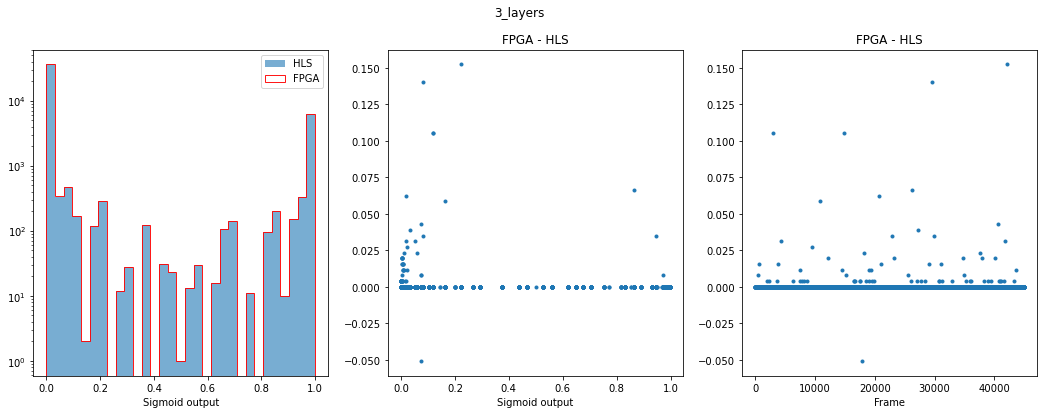

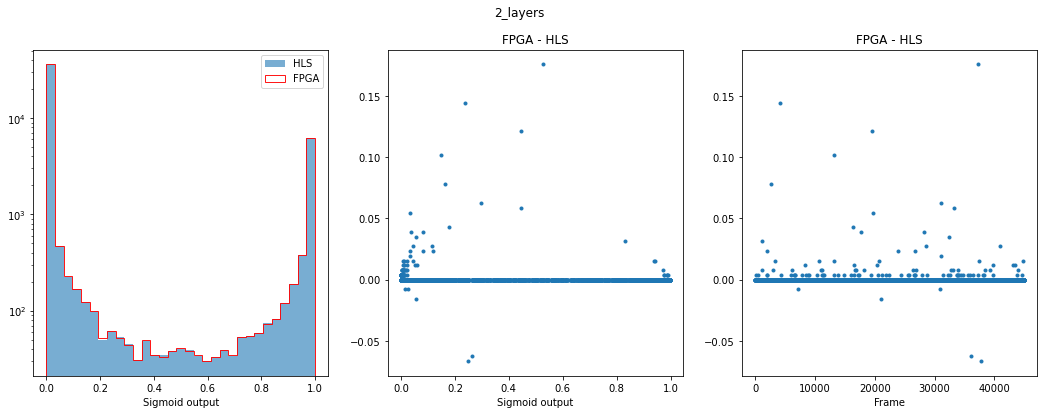

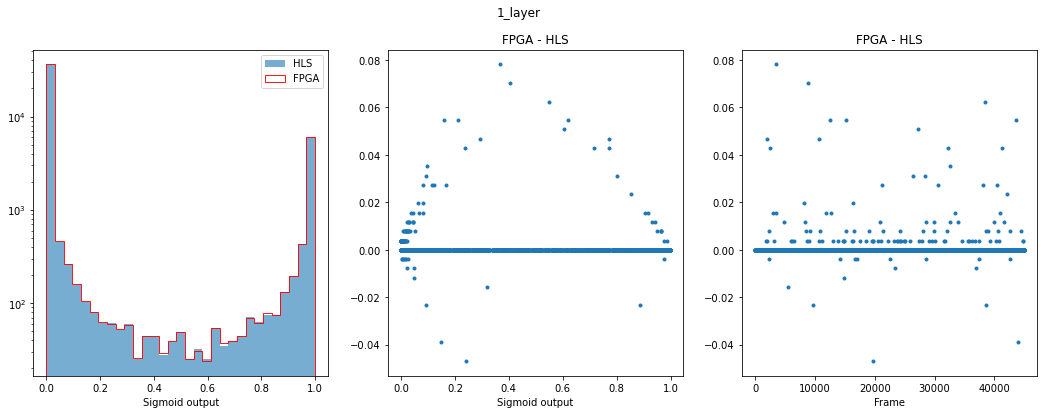

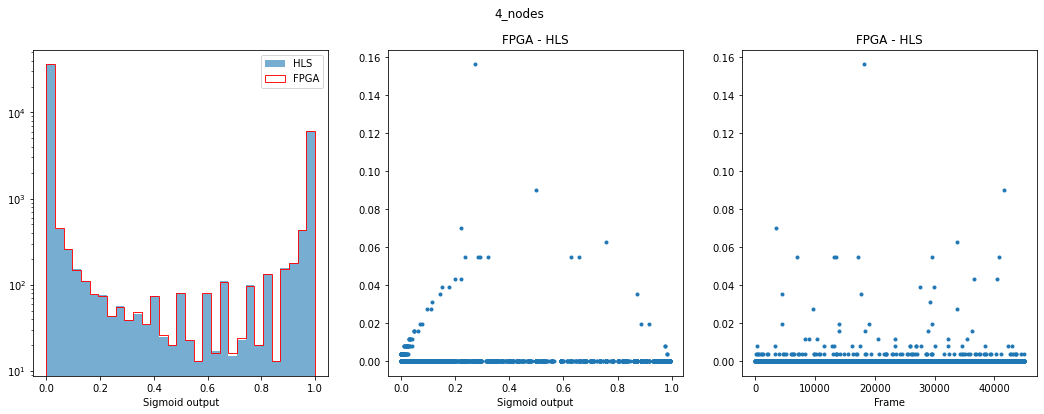

In [35]:
bins = np.linspace(0,1,32)

for NN_label in labels:

    f,axs = plt.subplots(1,3,figsize = (18,6))
    
    plt.suptitle(NN_label)
    
    #ref_q = np.uint8(y_qkeras[label][0:len(y_fpga[label])]*256)/256
    #ref = decode(encode_floor(ref))
    
    ref = y_hls[NN_label][0:len(result[NN_label])]
    #ref = decode(encode_floor(ref))

    ax = axs[0]
    _ = ax.hist(ref, bins = bins, alpha = 0.6, label = "HLS")
    
    #_ = ax.hist(ref_q, bins = bins, histtype = "step", alpha = 0.6, label = "qkeras")

    test = result[NN_label]
    
    #test.hist(label = "FPGA", bins = bins, histtype = "step", ax = ax)
    _ = ax.hist(test, bins = bins, histtype = "step", alpha = 0.9, color="red", label = "FPGA")

    #axs[1].plot(ref_q, test - ref_q, '.', alpha = 0.4)
    axs[1].plot(ref  , test - ref, '.')
    #axs[2].plot(test - ref_q, '.', alpha = 0.4)
    axs[2].plot(test - ref, '.')
    
    ax.legend(title = "")
    ax.set_yscale('log')
    ax.set_xlabel('Sigmoid output')

    ax = axs[1]
    ax.set_xlabel("Sigmoid output")
    ax.set_title("FPGA - HLS")

    ax = axs[2]
    ax.set_xlabel("Frame")
    ax.set_title("FPGA - HLS")
    #ax.legend()
    
    figname = "Images/" + NN_label + "-FPGAvsHLS_480.png"
    plt.savefig(figname)

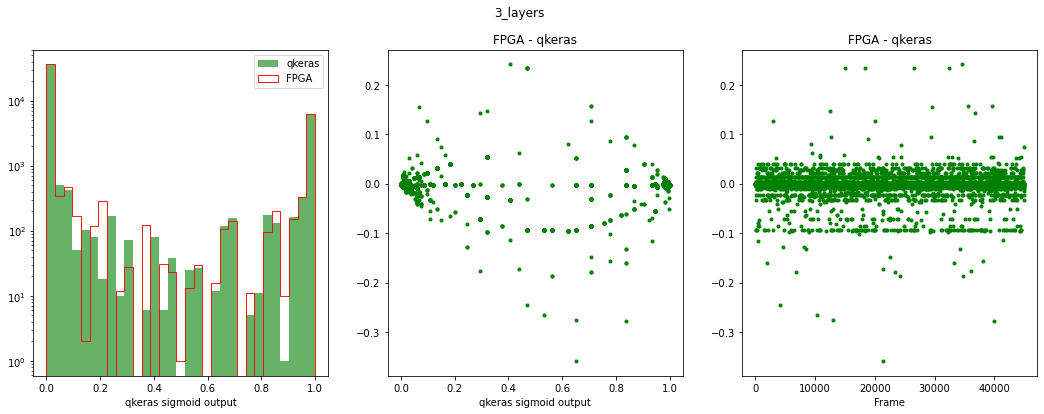

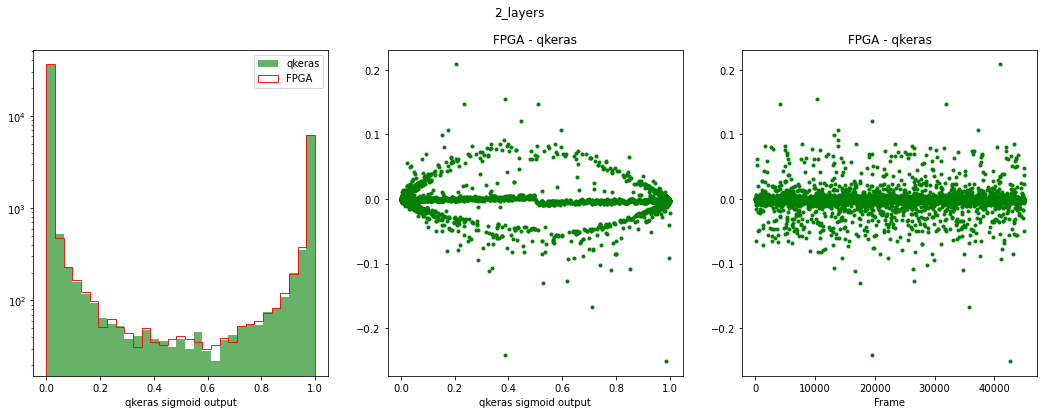

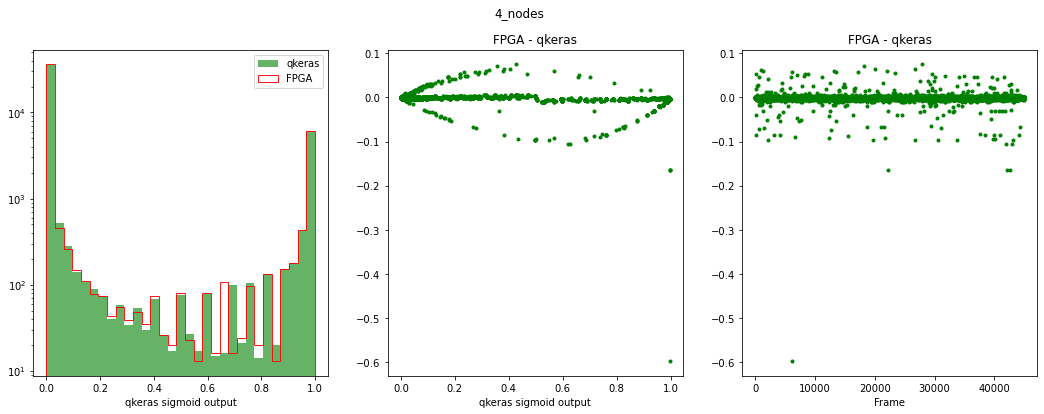

In [36]:
bins = np.linspace(0,1,32)

for NN_label in labels:

    f,axs = plt.subplots(1,3,figsize = (18,6))
    
    plt.suptitle(NN_label)
    
    #ref_q = np.uint8(y_qkeras[label][0:len(y_fpga[label])]*256)/256
    #ref = decode(encode_floor(ref))
    
    ref = y_qkeras[NN_label][0:len(result[NN_label])]
    #ref = decode(encode_floor(ref))

    ax = axs[0]
    _ = ax.hist(ref, bins = bins, alpha = 0.6, color='green', label = "qkeras")
    
    #_ = ax.hist(ref_q, bins = bins, histtype = "step", alpha = 0.6, label = "qkeras")

    test = result[NN_label]
    
    #test.hist(label = "FPGA", bins = bins, histtype = "step", ax = ax)
    _ = ax.hist(test, bins = bins, histtype = "step", alpha = 0.9, color="red", label = "FPGA")

    #axs[1].plot(ref_q, test - ref_q, '.', alpha = 0.4)
    axs[1].plot(ref  , test - ref, '.', color='green')
    #axs[2].plot(test - ref_q, '.', alpha = 0.4)
    axs[2].plot(test - ref, '.', color='green')
    
    ax.legend(title = "")
    ax.set_yscale('log')
    ax.set_xlabel('qkeras sigmoid output')

    ax = axs[1]
    ax.set_xlabel("qkeras sigmoid output")
    ax.set_title("FPGA - qkeras")

    ax = axs[2]
    ax.set_xlabel("Frame")
    ax.set_title("FPGA - qkeras")
    #ax.legend()
    
    figname = "Images/" + NN_label + "-FPGAvsqkeras_480.png"
    plt.savefig(figname)

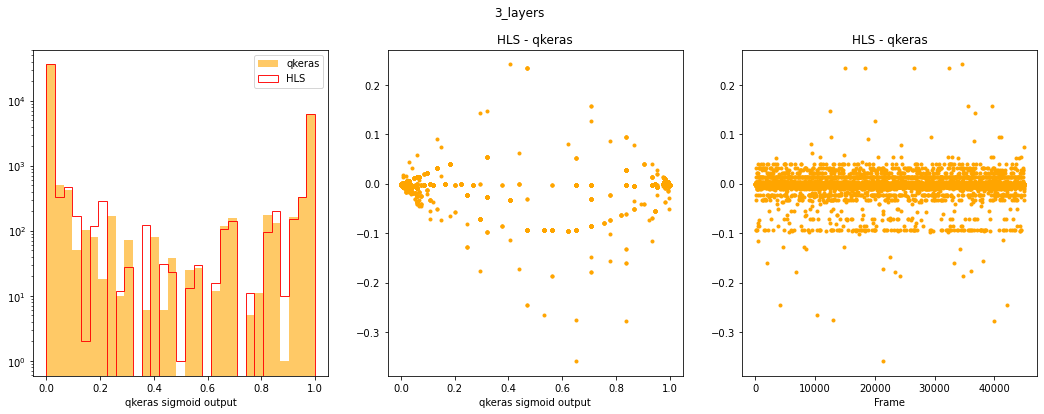

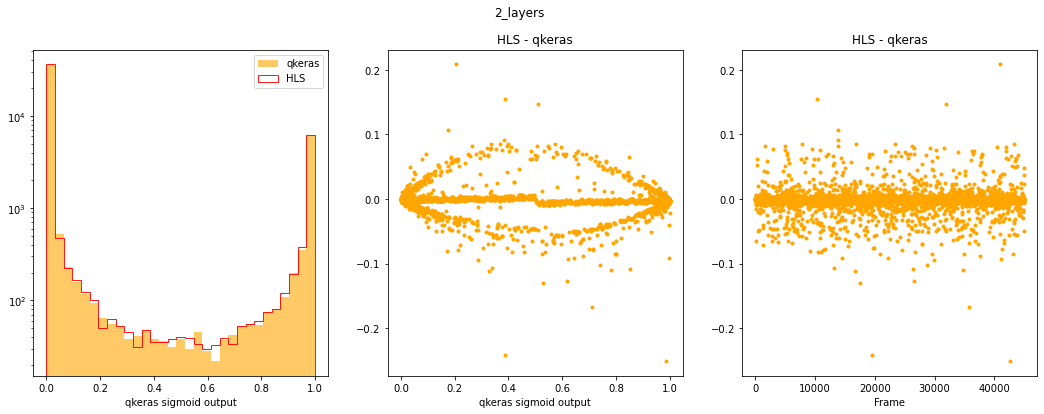

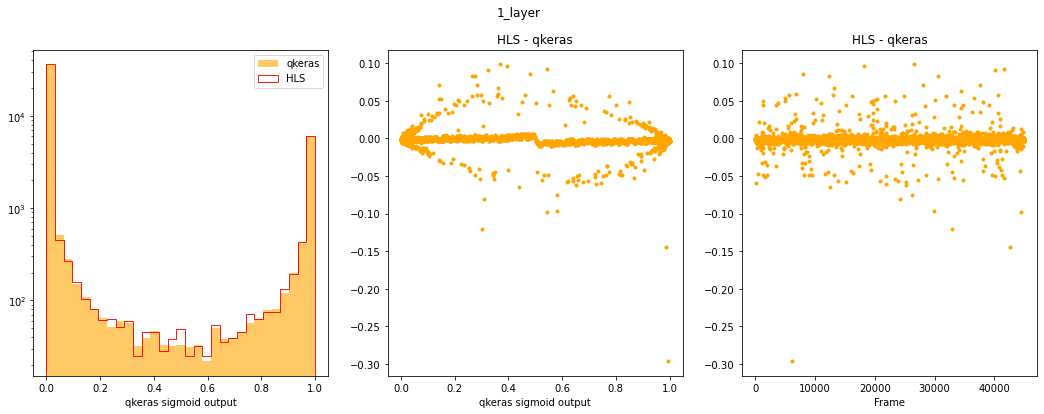

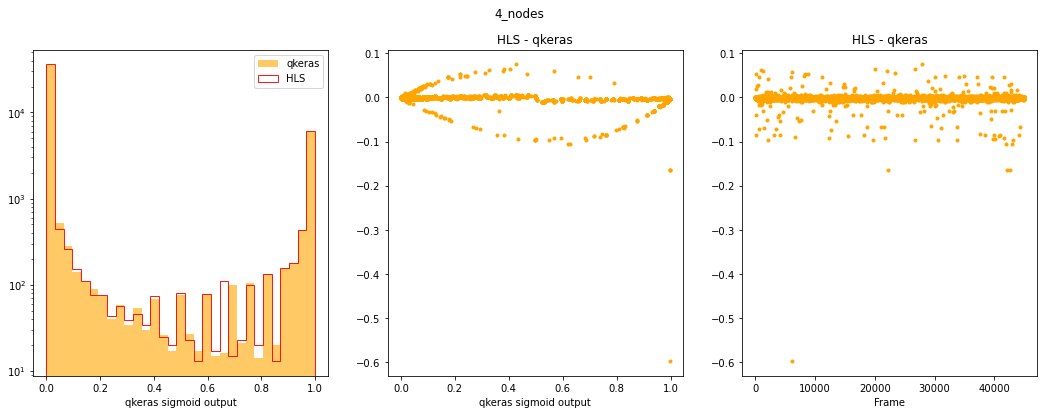

In [37]:
bins = np.linspace(0,1,32)

for NN_label in labels:

    f,axs = plt.subplots(1,3,figsize = (18,6))
    
    plt.suptitle(NN_label)
    
    #ref_q = np.uint8(y_qkeras[label][0:len(y_fpga[label])]*256)/256
    #ref = decode(encode_floor(ref))
    
    ref = y_qkeras[NN_label][0:len(result[NN_label])]
    #ref = decode(encode_floor(ref))

    ax = axs[0]
    _ = ax.hist(ref, bins = bins, alpha = 0.6, color='orange', label = "qkeras")
    
    #_ = ax.hist(ref_q, bins = bins, histtype = "step", alpha = 0.6, label = "qkeras")

    test = y_hls[NN_label][0:len(result[NN_label])]
    
    #test.hist(label = "FPGA", bins = bins, histtype = "step", ax = ax)
    _ = ax.hist(test, bins = bins, histtype = "step", alpha = 0.9, color="red", label = "HLS")

    #axs[1].plot(ref_q, test - ref_q, '.', alpha = 0.4)
    axs[1].plot(ref  , test - ref, '.', color='orange')
    #axs[2].plot(test - ref_q, '.', alpha = 0.4)
    axs[2].plot(test - ref, '.', color='orange')
    
    ax.legend(title = "")
    ax.set_yscale('log')
    ax.set_xlabel('qkeras sigmoid output')

    ax = axs[1]
    ax.set_xlabel("qkeras sigmoid output")
    ax.set_title("HLS - qkeras")

    ax = axs[2]
    ax.set_xlabel("Frame")
    ax.set_title("HLS - qkeras")
    #ax.legend()
    
    figname = "Images/" + NN_label + "-HLSvsqkeras_480.png"
    plt.savefig(figname)

## Scaler test

![Firmware layout_scaler](Images/NN_480MHz_scaler.png)

In [38]:
# Imports and defs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patternfiles import *
from bitstringconverter import *

In [39]:
y_test     = np.load("Data/y_test_1ele_sigmoid.npy")
y_test     = np.reshape(y_test, (len(y_test),))
X_test_hw  = np.load("Data/X_test_hw.npy")

In [40]:
def prep_bitstring_hwdata(data_int_new):
    
    # for hw values we start from integers from the beginning (no need for fractional bits)
    data_int_new = convert_to_ap_ufixed(data_int_new, 16, 16)
    
    # Step 2: convert to bitstrings
    formatstring = np.full(17, "uint:16")
    data_bitstring = pack_vec(formatstring, data_int_new)
    
    # Step 3: Add required padding\
    data_bitstring_padded = padd_vec(data_bitstring, 16)
    
    return data_bitstring_padded

In [ ]:
debug = False

output_data = {}

chunk_length = 900
max_chunks = 50

#for label, int_data in int_data_options.items():
for chunk in range(max_chunks):
    label = "chunk_%i" %chunk
    print(label)
    
    X_test_chunk = X_test_hw[chunk * chunk_length: (chunk+1) * chunk_length]
    
    data_bitstring_padded = prep_bitstring_hwdata(X_test_chunk)
    # write out fname
    indir = "Pattern_files"
    fname = indir + "/hls4ml_input_pattern_scaler_%s.txt" % label
    #fname = indir + "/finor_test_%s.txt" % label
    write_pattern_file(data_bitstring_padded, outputfile=fname, linkOffset=60)
    # checking created fil
    if debug:
        f = open(fname, 'r')
        print(f.readlines()[20])
        

In [ ]:
mamax_chunks = 50
output_data = {}
column = []
labels = ["3_layers", "2_layers", "1_layer", "4_nodes"]
result = {}
for label in labels:
    result[label] = np.array([])

#for label, int_data in int_data_options.items():
for chunk in range(max_chunks):
    label = "chunk_%i" %chunk
    print(label)
    fname = "Pattern_files/tx_datascaler_480_%s.txt" %label
    
    ## read output
    # Step 1: Reading in pattern file
    with open(fname) as f:
        
        # Crosscheck whether this has the structure of a pattern file
        line = f.readline() # this should be the "Board XXXX" line
        if(line.find("Board") == -1): raise NameError("Not a pattern file!")
        else: print("Found board: "+line.split(" ",1)[1].rstrip('\n'))
        line = f.readline() # this should be the "Quad/Chan" line
        if(line.find("Quad/Chan") == -1): raise NameError("Not a pattern file!")
        line = f.readline() # this should be the "Link" line
        if(line.find("Link") == -1): raise NameError("Not a pattern file!")
        else: 
            tempstring = line.split(": ", 1)[1]
            tempstring = ' '.join(tempstring.split())
            col_count = len(tempstring.split(" "))
            print("Found "+str(col_count)+" links.")

        line = f.readline() # this should be the first content line
        linearrays = []
        i = 0
        output_data = np.empty((1024,4), dtype=np.uint64)
        while line:
            tempstring = line.split(": ", 1)[1].rstrip('\n')#[:-1] TODO fix this, should strip final spaces as well
            linearray = np.array(tempstring.split(" "))
            for j in range(len(linearray)):
                if linearray[j][0]=='1':
                    output_data[i,j]=int(linearray[j][2:18],16)
                else:
                    output_data[i,j]=2**64-1
            i = i+1
            if(np.all(find_valid_bit(linearray)) or True): # skipping lines with invalid bits
                linearrays.append(remove_validity_bit(linearray)) # stripping the validity bits
            line = f.readline()
            
    i = 0

    for label in labels:
        temp_res = output_data[:,i]
        temp_res = temp_res[temp_res!=2**64-1]
        result[label] = np.append(result[label],temp_res/2**8)
        i = i+1

In [ ]:
np.stack((y_test[:len(result["3_layers"])], result["3_layers"]), axis=-1)

In [43]:
y_hls    = {}
y_qkeras = {}


for label in labels:
    fname = "Data/y_hls_" + label + "_1ele_sigmoid_480.npy"
    y_hls[label] = np.load(fname)
    y_hls[label] = np.reshape(y_hls[label], (len(y_hls[label]),))
    fname = "Data/y_qkeras_" + label + "_1ele_sigmoid_480.npy"
    y_qkeras[label] = np.load(fname)
    y_qkeras[label] = np.reshape(y_qkeras[label], (len(y_qkeras[label]),))

---------------------3_layers---------------------
Accuracy hls4ml  : 98.891%
Accuracy FPGA inf: 98.896%
AUC score hls4ml   : 97.882%
AUC score FPGA inf : 97.858%
-------------------------------------------------
---------------------2_layers---------------------
Accuracy hls4ml  : 98.902%
Accuracy FPGA inf: 98.904%
AUC score hls4ml   : 97.981%
AUC score FPGA inf : 97.955%
-------------------------------------------------
---------------------1_layer---------------------
Accuracy hls4ml  : 98.953%
Accuracy FPGA inf: 98.949%
AUC score hls4ml   : 97.973%
AUC score FPGA inf : 97.960%
-------------------------------------------------
---------------------4_nodes---------------------
Accuracy hls4ml  : 98.824%
Accuracy FPGA inf: 98.840%
AUC score hls4ml   : 97.923%
AUC score FPGA inf : 97.922%
-------------------------------------------------


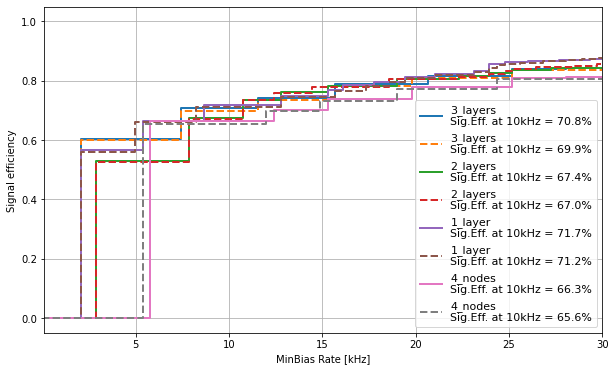

In [44]:
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import accuracy_score


LHCfreq = 11245.6 
nCollBunch = 2760

minbias_rate = LHCfreq * nCollBunch /1e3 # in kHz

f,ax1  = plt.subplots(figsize = (10,6))
legend_size = 14   
lim=20

rocs_qkeras = {}
rocs_fpga   = {}

thr = 1/2**1

for label in labels:
    
    y_temp_hls = np.copy(y_hls[label])
    y_temp_hls[y_hls[label]>=thr]  = 1.
    y_temp_hls[y_hls[label]<thr] = 0.
    
    y_temp_fpga = np.copy(result[label])
    y_temp_fpga[result[label]>=thr]  = 1.
    y_temp_fpga[result[label]<thr] = 0.
    
    print("---------------------" + label + "---------------------")
    
    #print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
    print("Accuracy hls4ml  : {:.3f}".format(accuracy_score(y_test[0:len(y_temp_fpga)], y_temp_hls[0:len(y_temp_fpga)])*100) + "%")
    print("Accuracy FPGA inf: {:.3f}".format(accuracy_score(y_test[0:len(y_temp_fpga)], y_temp_fpga)*100) + "%")
    
    print("AUC score hls4ml   : {:.3f}".format(roc_auc_score(y_test[0:len(y_temp_fpga)], y_temp_hls[0:len(y_temp_fpga)])*100) + "%")
    print("AUC score FPGA inf : {:.3f}".format(roc_auc_score(y_test[0:len(y_temp_fpga)], y_temp_fpga)*100) + "%")
    print("-------------------------------------------------")
    
    
    rocs_hls    = roc_curve(y_test[0:len(y_temp_fpga)], y_hls[label][0:len(y_temp_fpga)])
    rocs_fpga   = roc_curve(y_test[0:len(y_temp_fpga)], result[label], drop_intermediate=False)
    
    
    #plt.plot(rocs_qkeras[0],rocs_qkeras[1]*minbias_rate,"-",label="qkeras")
    index = np.abs(rocs_hls[0]*minbias_rate - 10).argmin()
    sig_eff_hls= rocs_hls[1][index]
    eff_string_hls= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_hls*100,1))
    ax1.plot(rocs_hls[0]*minbias_rate,rocs_hls[1],"-",label=label+"\n"+eff_string_hls,lw=2, drawstyle='steps-mid')
    #plt.plot(rocs_qkeras[0],rocs_qkeras[1]*minbias_rate,"-",label="qkeras")
    index = np.abs(rocs_fpga[0]*minbias_rate - 10).argmin()
    sig_eff_fpga= rocs_fpga[1][index]
    eff_string_fpga= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_fpga*100,1))
    ax1.plot(rocs_fpga[0]*minbias_rate,rocs_fpga[1],"--",label=label+"\n"+eff_string_fpga,lw=2, drawstyle='steps-mid')
    

    #plt.plot(rocs_hls[0],rocs_hls[1]*minbias_rate,"--",label="hls")

    ax1.legend(prop={'size': 11},loc = "lower right")
    ax1.set_xlabel("MinBias Rate [kHz]")
    ax1.set_ylabel("Signal efficiency")

    #ax1.set_xscale("log")
    ax1.set_xlim(0.1,30)
    #plt.ylim(0,20)
    ax1.grid(True)

plt.show()

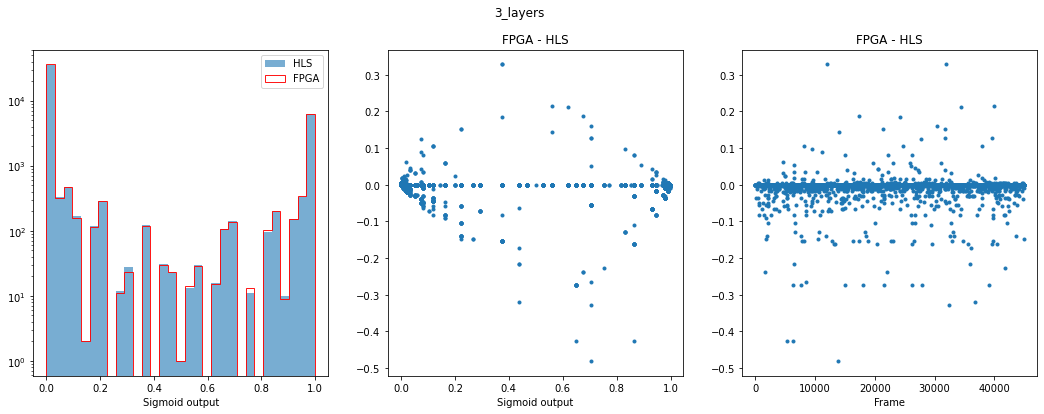

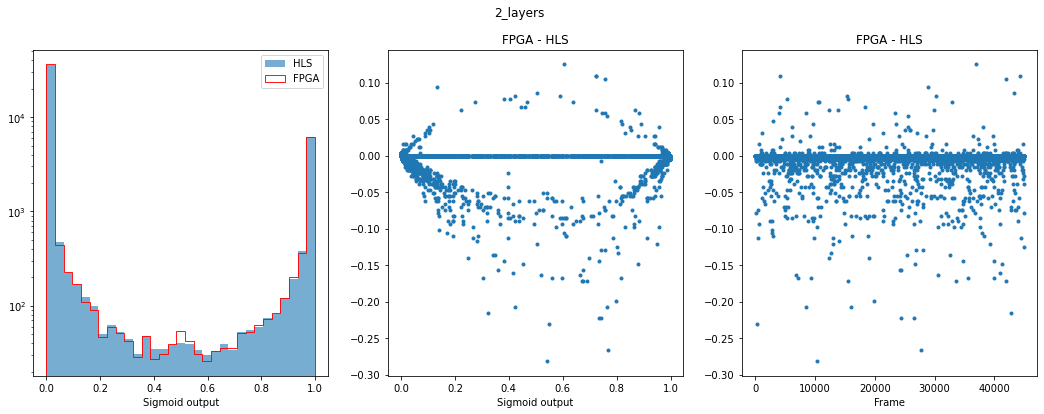

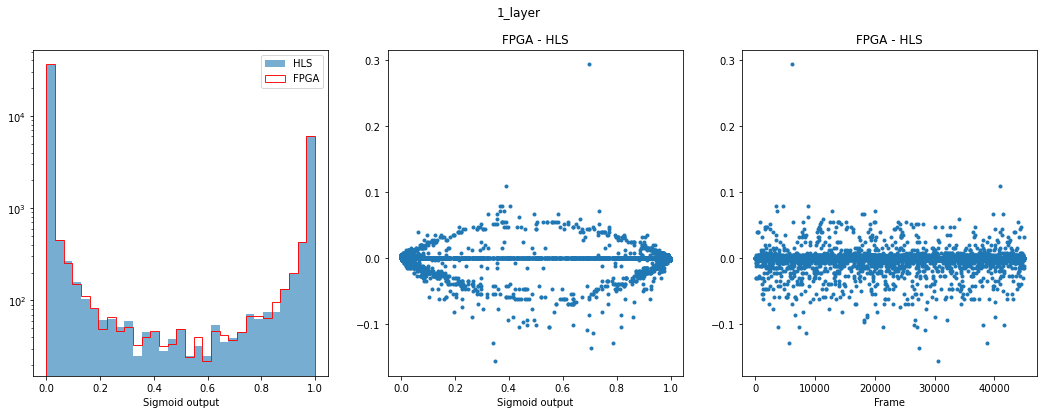

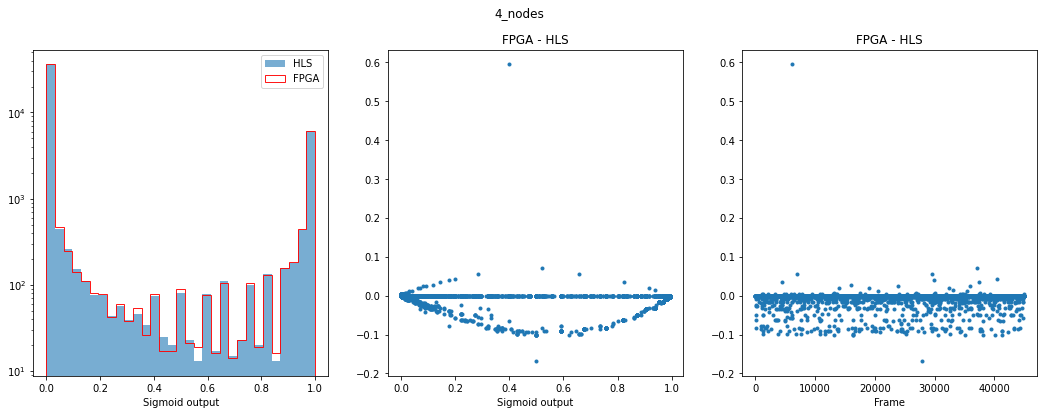

In [45]:
bins = np.linspace(0,1,32)

for NN_label in labels:

    f,axs = plt.subplots(1,3,figsize = (18,6))
    
    plt.suptitle(NN_label)
    
    #ref_q = np.uint8(y_qkeras[label][0:len(y_fpga[label])]*256)/256
    #ref = decode(encode_floor(ref))
    
    ref = y_hls[NN_label][0:len(result[NN_label])]
    #ref = decode(encode_floor(ref))

    ax = axs[0]
    _ = ax.hist(ref, bins = bins, alpha = 0.6, label = "HLS")
    
    #_ = ax.hist(ref_q, bins = bins, histtype = "step", alpha = 0.6, label = "qkeras")

    test = result[NN_label]
    
    #test.hist(label = "FPGA", bins = bins, histtype = "step", ax = ax)
    _ = ax.hist(test, bins = bins, histtype = "step", alpha = 0.9, color="red", label = "FPGA")

    #axs[1].plot(ref_q, test - ref_q, '.', alpha = 0.4)
    axs[1].plot(ref  , test - ref, '.')
    #axs[2].plot(test - ref_q, '.', alpha = 0.4)
    axs[2].plot(test - ref, '.')
    
    ax.legend(title = "")
    ax.set_yscale('log')
    ax.set_xlabel('Sigmoid output')

    ax = axs[1]
    ax.set_xlabel("Sigmoid output")
    ax.set_title("FPGA - HLS")

    ax = axs[2]
    ax.set_xlabel("Frame")
    ax.set_title("FPGA - HLS")
    #ax.legend()
    
    figname = "Images/" + NN_label + "-scaler-FPGAvsHLS_480.png"
    plt.savefig(figname)

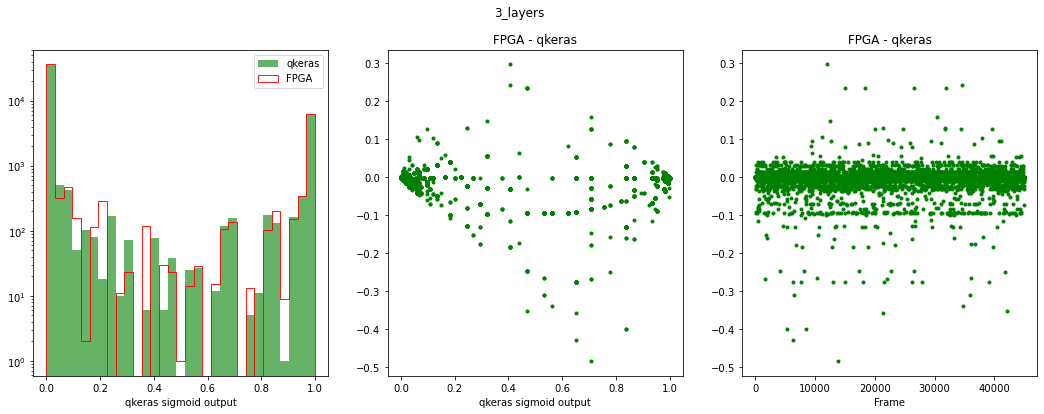

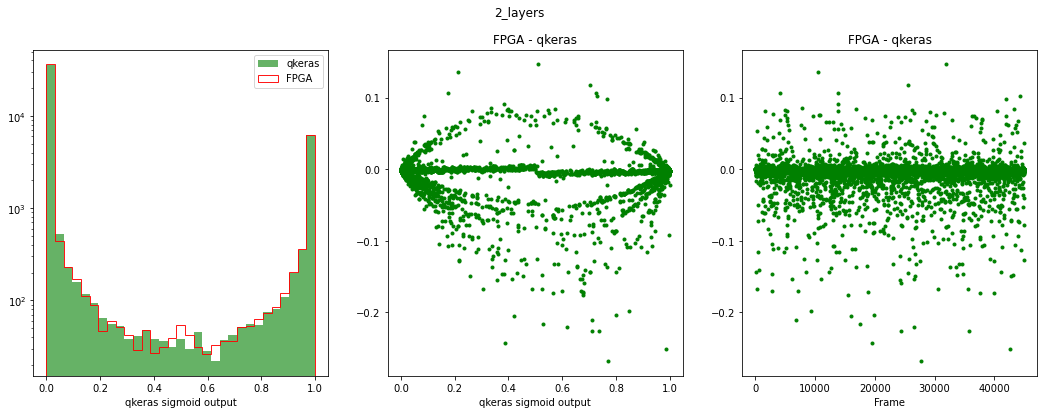

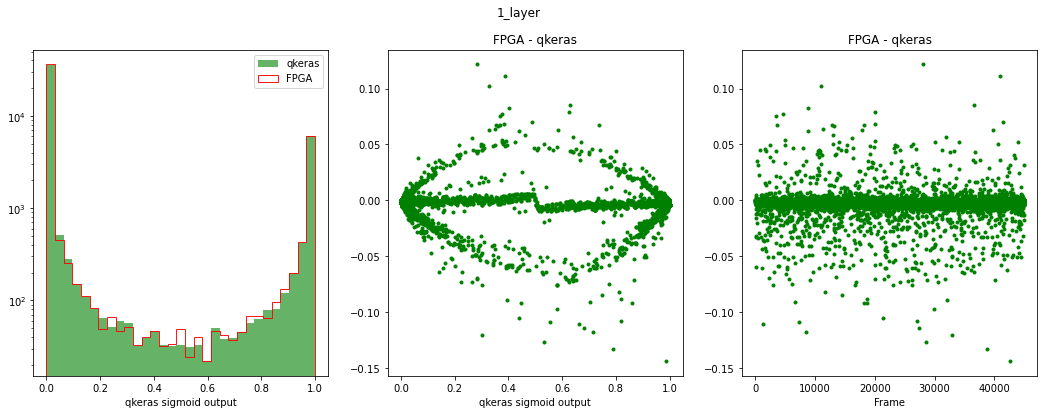

In [46]:
bins = np.linspace(0,1,32)

for NN_label in labels:

    f,axs = plt.subplots(1,3,figsize = (18,6))
    
    plt.suptitle(NN_label)
    
    #ref_q = np.uint8(y_qkeras[label][0:len(y_fpga[label])]*256)/256
    #ref = decode(encode_floor(ref))
    
    ref = y_qkeras[NN_label][0:len(result[NN_label])]
    #ref = decode(encode_floor(ref))

    ax = axs[0]
    _ = ax.hist(ref, bins = bins, alpha = 0.6, color='green', label = "qkeras")
    
    #_ = ax.hist(ref_q, bins = bins, histtype = "step", alpha = 0.6, label = "qkeras")

    test = result[NN_label]
    
    #test.hist(label = "FPGA", bins = bins, histtype = "step", ax = ax)
    _ = ax.hist(test, bins = bins, histtype = "step", alpha = 0.9, color="red", label = "FPGA")

    #axs[1].plot(ref_q, test - ref_q, '.', alpha = 0.4)
    axs[1].plot(ref  , test - ref, '.', color='green')
    #axs[2].plot(test - ref_q, '.', alpha = 0.4)
    axs[2].plot(test - ref, '.', color='green')
    
    ax.legend(title = "")
    ax.set_yscale('log')
    ax.set_xlabel('qkeras sigmoid output')

    ax = axs[1]
    ax.set_xlabel("qkeras sigmoid output")
    ax.set_title("FPGA - qkeras")

    ax = axs[2]
    ax.set_xlabel("Frame")
    ax.set_title("FPGA - qkeras")
    #ax.legend()
    
    figname = "Images/" + NN_label + "-scaler-FPGAvsqkeras_480.png"
    plt.savefig(figname)

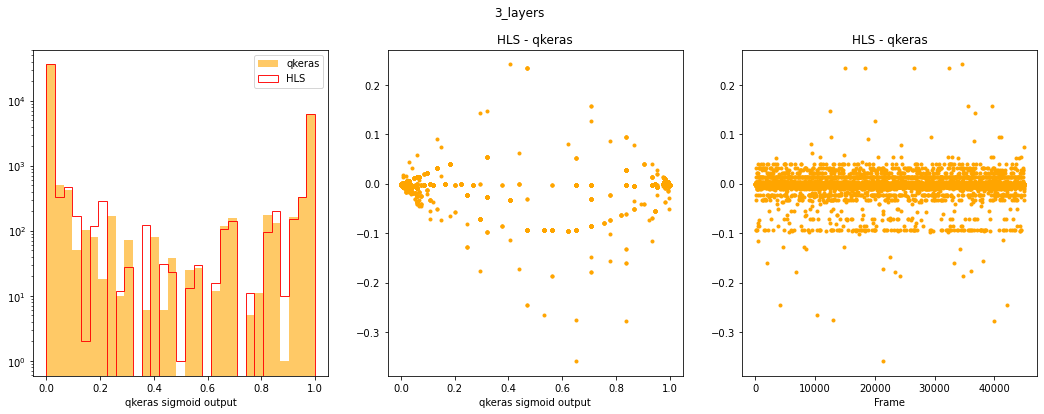

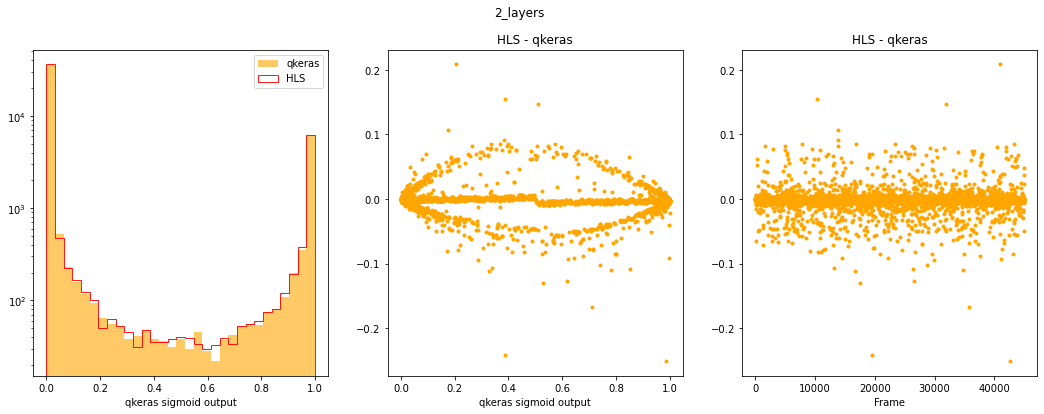

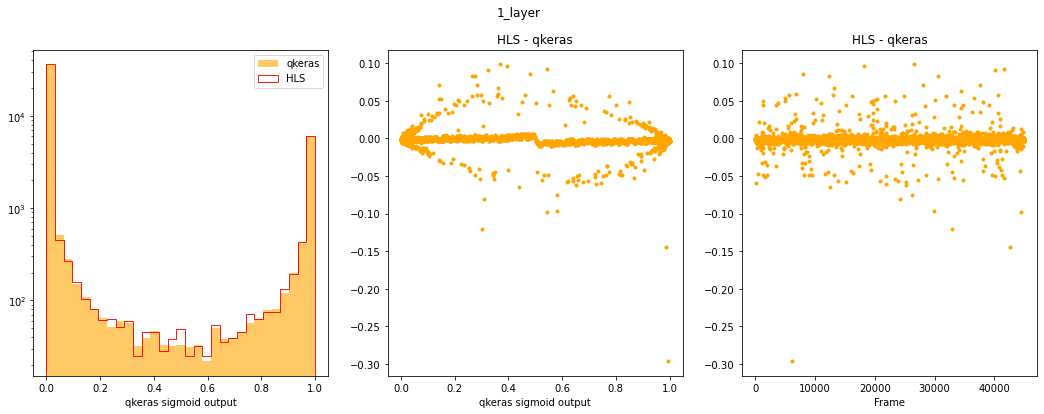

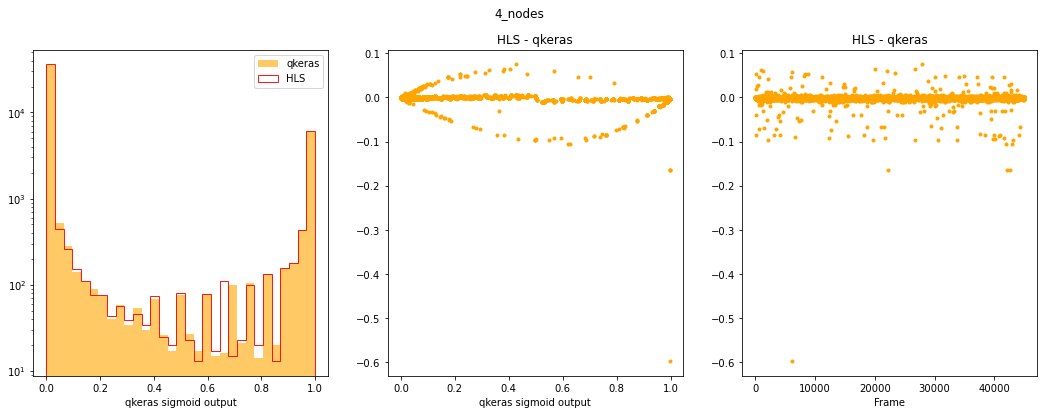

In [47]:
bins = np.linspace(0,1,32)

for NN_label in labels:

    f,axs = plt.subplots(1,3,figsize = (18,6))
    
    plt.suptitle(NN_label)
    
    #ref_q = np.uint8(y_qkeras[label][0:len(y_fpga[label])]*256)/256
    #ref = decode(encode_floor(ref))
    
    ref = y_qkeras[NN_label][0:len(result[NN_label])]
    #ref = decode(encode_floor(ref))

    ax = axs[0]
    _ = ax.hist(ref, bins = bins, alpha = 0.6, color='orange', label = "qkeras")
    
    #_ = ax.hist(ref_q, bins = bins, histtype = "step", alpha = 0.6, label = "qkeras")

    test = y_hls[NN_label][0:len(result[NN_label])]
    
    #test.hist(label = "FPGA", bins = bins, histtype = "step", ax = ax)
    _ = ax.hist(test, bins = bins, histtype = "step", alpha = 0.9, color="red", label = "HLS")

    #axs[1].plot(ref_q, test - ref_q, '.', alpha = 0.4)
    axs[1].plot(ref  , test - ref, '.', color='orange')
    #axs[2].plot(test - ref_q, '.', alpha = 0.4)
    axs[2].plot(test - ref, '.', color='orange')
    
    ax.legend(title = "")
    ax.set_yscale('log')
    ax.set_xlabel('qkeras sigmoid output')

    ax = axs[1]
    ax.set_xlabel("qkeras sigmoid output")
    ax.set_title("HLS - qkeras")

    ax = axs[2]
    ax.set_xlabel("Frame")
    ax.set_title("HLS - qkeras")
    #ax.legend()
    
    figname = "Images/" + NN_label + "-scaler-HLSvsqkeras_480.png"
    plt.savefig(figname)

# No-Scaler vs Scaler

---------------------3_layers---------------------
Accuracy FPGA without scaler  : 98.891%
Accuracy FPGA with scaler     : 98.896%
AUC score FPGA without scaler : 97.882%
AUC score FPGA with scaler    : 97.858%
-------------------------------------------------
---------------------2_layers---------------------
Accuracy FPGA without scaler  : 98.898%
Accuracy FPGA with scaler     : 98.904%
AUC score FPGA without scaler : 97.978%
AUC score FPGA with scaler    : 97.955%
-------------------------------------------------
---------------------1_layer---------------------
Accuracy FPGA without scaler  : 98.953%
Accuracy FPGA with scaler     : 98.949%
AUC score FPGA without scaler : 97.973%
AUC score FPGA with scaler    : 97.960%
-------------------------------------------------
---------------------4_nodes---------------------
Accuracy FPGA without scaler  : 98.824%
Accuracy FPGA with scaler     : 98.840%
AUC score FPGA without scaler : 97.923%
AUC score FPGA with scaler    : 97.922%
--------

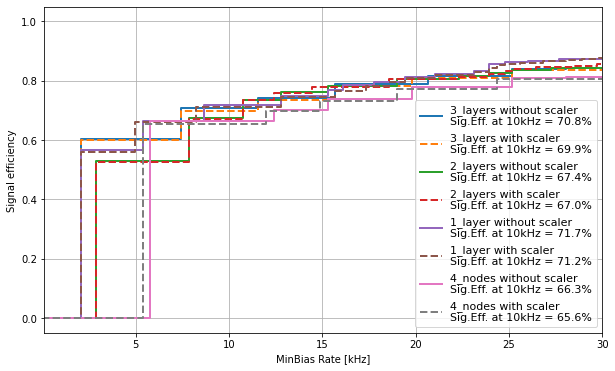

In [55]:
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import accuracy_score


LHCfreq = 11245.6 
nCollBunch = 2760

minbias_rate = LHCfreq * nCollBunch /1e3 # in kHz

f,ax1  = plt.subplots(figsize = (10,6))
legend_size = 14   
lim=20

rocs_qkeras = {}
rocs_fpga   = {}

thr = 1/2**1

for label in labels:
    
    y_temp_fpga_ns = np.copy(result_noscaler[label])
    y_temp_fpga_ns[result_noscaler[label]>=thr]  = 1.
    y_temp_fpga_ns[result_noscaler[label]<thr] = 0.
    
    y_temp_fpga_s = np.copy(result[label])
    y_temp_fpga_s[result[label]>=thr]  = 1.
    y_temp_fpga_s[result[label]<thr] = 0.
    
    print("---------------------" + label + "---------------------")
    
    #print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
    print("Accuracy FPGA without scaler  : {:.3f}".format(accuracy_score(y_test[0:len(y_temp_fpga_ns)], y_temp_fpga_ns)*100) + "%")
    print("Accuracy FPGA with scaler     : {:.3f}".format(accuracy_score(y_test[0:len(y_temp_fpga_s)], y_temp_fpga_s)*100) + "%")
    
    print("AUC score FPGA without scaler : {:.3f}".format(roc_auc_score(y_test[0:len(y_temp_fpga_ns)], y_temp_fpga_ns)*100) + "%")
    print("AUC score FPGA with scaler    : {:.3f}".format(roc_auc_score(y_test[0:len(y_temp_fpga_s)], y_temp_fpga_s)*100) + "%")
    print("-------------------------------------------------")
    
    
    rocs_fpga_ns  = roc_curve(y_test[0:len(y_temp_fpga)], result_noscaler[label], drop_intermediate=False)
    rocs_fpga_s   = roc_curve(y_test[0:len(y_temp_fpga)], result[label]         , drop_intermediate=False)
    
    
    #plt.plot(rocs_qkeras[0],rocs_qkeras[1]*minbias_rate,"-",label="qkeras")
    index = np.abs(rocs_fpga_ns[0]*minbias_rate - 10).argmin()
    sig_eff_ns= rocs_fpga_ns[1][index]
    eff_string_ns= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_ns*100,1))
    ax1.plot(rocs_fpga_ns[0]*minbias_rate,rocs_fpga_ns[1],"-",label=label+" without scaler\n"+eff_string_ns,lw=2, drawstyle='steps-mid')
    #plt.plot(rocs_qkeras[0],rocs_qkeras[1]*minbias_rate,"-",label="qkeras")
    index = np.abs(rocs_fpga_s[0]*minbias_rate - 10).argmin()
    sig_eff_s= rocs_fpga_s[1][index]
    eff_string_s= "Sig.Eff. at 10kHz = {}%".format(round(sig_eff_s*100,1))
    ax1.plot(rocs_fpga_s[0]*minbias_rate,rocs_fpga_s[1],"--",label=label+" with scaler\n"+eff_string_s,lw=2, drawstyle='steps-mid')
    

    #plt.plot(rocs_hls[0],rocs_hls[1]*minbias_rate,"--",label="hls")

    ax1.legend(prop={'size': 11},loc = "lower right")
    ax1.set_xlabel("MinBias Rate [kHz]")
    ax1.set_ylabel("Signal efficiency")

    #ax1.set_xscale("log")
    ax1.set_xlim(0.1,30)
    #plt.ylim(0,20)
    ax1.grid(True)

plt.show()